## Imports

In [1]:
import pandas as pd
import os
from openpyxl import Workbook
from simplified_scrapy import SimplifiedDoc, utils
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
pd.set_option('display.float_format', '{:.2f}'.format)

## Morningstar dataset conversion to Excel file (.xlsx)

In [2]:
"""
import os
files = []
for i in os.walk('./datasets'):
    files= i[2]
    
print(files)
"""

"\nimport os\nfiles = []\nfor i in os.walk('./datasets'):\n    files= i[2]\n    \nprint(files)\n"

In [3]:
"""
def readFile(filename):
    xml = utils.getFileContent(filename)
    doc = SimplifiedDoc(xml)
    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data
    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name
    return sheetNames,tables,filename.split('/')[2].split('.')[0]

def to_Excel(sheetNames,tables, filename):
    wb = Workbook() # Create Workbook
    for i in range(len(sheetNames)):
        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet
        for row in tables[i]:
            worksheet.append(row)
    print('./datasets_excel/'+ filename + '.xlsx')
    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file
"""

"\ndef readFile(filename):\n    xml = utils.getFileContent(filename)\n    doc = SimplifiedDoc(xml)\n    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data\n    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name\n    return sheetNames,tables,filename.split('/')[2].split('.')[0]\n\ndef to_Excel(sheetNames,tables, filename):\n    wb = Workbook() # Create Workbook\n    for i in range(len(sheetNames)):\n        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet\n        for row in tables[i]:\n            worksheet.append(row)\n    print('./datasets_excel/'+ filename + '.xlsx')\n    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file\n"

In [4]:
"""
for filename in (os.listdir("./datasets")):
        name = filename.split('.')[0]
        print(name)
        
        dst = name + ".xml"
        src ='./datasets/'+ filename
        dst ='./datasets/'+ dst
          
        # rename() function will
        # rename all the files
        os.rename(src, dst)
"""

'\nfor filename in (os.listdir("./datasets")):\n        name = filename.split(\'.\')[0]\n        print(name)\n        \n        dst = name + ".xml"\n        src =\'./datasets/\'+ filename\n        dst =\'./datasets/\'+ dst\n          \n        # rename() function will\n        # rename all the files\n        os.rename(src, dst)\n'

In [5]:
"""
for file in files:
    to_Excel(*readFile("./datasets/" + file))
"""

'\nfor file in files:\n    to_Excel(*readFile("./datasets/" + file))\n'

## Import datasets into Pandas dataframes

In [6]:
files = []
for i in os.walk('./datasets_excel/'):
    files=i[2]

workbooks = {}
for file in files:
    workbooks[file.split('.')[0]] = pd.read_excel('./datasets_excel/' + file, sheet_name=None)

In [7]:
print(list(workbooks.keys()))

['ADH_FY', 'ADH_HY', 'ANZ_FY', 'ANZ_HY', 'BCI_FY', 'BCI_HY', 'BFG_FY', 'BFG_HY', 'BHP_FY', 'BHP_HY', 'BNL_FY', 'BNL_HY', 'BPG_FY', 'BPG_HY', 'BTR_FY', 'BTR_HY', 'CBA_FY', 'CBA_HY', 'CCC_FY', 'CCC_HY', 'CIM_FY', 'CIM_HY', 'CVR_FY', 'CVR_HY', 'DGX_FY', 'DGX_HY', 'DTZ_FY', 'DTZ_HY', 'GMN_FY', 'GMN_HY', 'HWK_FY', 'HWK_HY', 'JBH_FY', 'JBH_HY', 'LCT_FY', 'LCT_HY', 'MEB_FY', 'MEB_HY', 'MFG_FY', 'MFG_HY', 'MGC_FY', 'MGC_HY', 'MQG_FY', 'MQG_HY', 'NAB_FY', 'NAB_HY', 'NCM_FY', 'NCM_HY', 'NGI_FY', 'NGI_HY', 'REX_FY', 'REX_HY', 'RIO_FY', 'RIO_HY', 'RNO_FY', 'RNO_HY', 'SRX_FY', 'SRX_HY', 'SRZ_FY', 'SRZ_HY', 'WBC_FY', 'WBC_HY', 'WCC_FY', 'WCC_HY']


## Cleaning

### Normalising statement items (WIP)

In [8]:
statement_items = defaultdict(set)

for workbook in workbooks:
    for sheet in workbooks[workbook]:
        if sheet != 'Sheet' and 'Item' in workbooks[workbook][sheet]:
            statement_items[sheet].update(workbooks[workbook][sheet]['Item'])
            
statement_items.keys()

dict_keys(['Profit Loss', 'Balance Sheet', 'Cash Flow', 'Per Share Statisticts', 'Sundry Analysis', 'Growth Rates', 'Ratio Analysis', 'Asset Base Analysis'])

### Restructuring datasets and creating combined HY and FY dataset

In [9]:
workbooks_combined = defaultdict(dict)
workbooks_keys = list(workbooks.keys())

for i in range(len(workbooks)//2):
    for sheet in statement_items:
        workbook_FY = workbooks[workbooks_keys[i*2]] # Reading in the full-yearly statements
        workbook_HY = workbooks[workbooks_keys[i*2 + 1]] # Reading in the half-yearly statements
        new_sheet = _ 
        
        if sheet in workbook_FY:
            sheet_FY = workbook_FY[sheet].drop(['ASX Code', 'Company Name'], axis=1)
            sheet_HY = workbook_HY[sheet].drop(['ASX Code', 'Company Name'], axis=1)

            new_sheet = pd.concat([sheet_FY, sheet_HY], axis=1, join='inner')
            new_sheet = new_sheet.loc[:,~new_sheet.columns.duplicated()] # Drop extra 'item' 
            new_sheet = new_sheet.set_index(['Item'])
            
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_combined[workbooks_keys[i*2].split('_')[0]][sheet] = new_sheet.transpose()    
        else:
            print("Missing tab:", workbooks_keys[i*2], sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis


In [10]:
workbooks_separated = defaultdict(lambda: defaultdict(dict))
workbooks_keys = list(workbooks.keys())

for workbook in workbooks:
    for sheet in statement_items:       
        if sheet in workbooks[workbook]:
            new_sheet = workbooks[workbook][sheet].drop(['ASX Code', 'Company Name'], axis=1)
            
            new_sheet = new_sheet.set_index(['Item'])
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_separated[workbook.split('_')[0]][workbook.split('_')[1]][sheet] = new_sheet.transpose()
        else:
            print("Missing tab:", workbook, sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: ANZ_HY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: CBA_HY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: NAB_HY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis
Missing tab: WBC_HY Sundry Analysis


In [11]:
# workbooks_combined_test[ticker][HY or FY][sheet name][item name]
workbooks_separated['ADH']['HY']['Profit Loss']['Operating Revenue']

2015-12-01   117821000.00
2016-12-01   124548000.00
2017-12-01   149047000.00
2018-12-01   164377000.00
2019-12-01   180273000.00
2020-12-01   242990000.00
Name: Operating Revenue, dtype: float64

In [12]:
workbooks_combined.keys()

dict_keys(['ADH', 'ANZ', 'BCI', 'BFG', 'BHP', 'BNL', 'BPG', 'BTR', 'CBA', 'CCC', 'CIM', 'CVR', 'DGX', 'DTZ', 'GMN', 'HWK', 'JBH', 'LCT', 'MEB', 'MFG', 'MGC', 'MQG', 'NAB', 'NCM', 'NGI', 'REX', 'RIO', 'RNO', 'SRX', 'SRZ', 'WBC', 'WCC'])

In [13]:
workbooks_combined['ADH']['Profit Loss'].head()

Item        Operating Revenue  Other Revenue  \
2014-12-01               0.00           0.00   
2015-06-01       210878000.00      166000.00   
2015-12-01       117821000.00      125000.00   
2016-06-01       253182000.00      406000.00   
2016-12-01       124548000.00       37000.00   

Item        Total Revenue Excluding Interest  Operating Expenses      EBITDA  \
2014-12-01                              0.00                0.00        0.00   
2015-06-01                      211044000.00       -188019000.00 23025000.00   
2015-12-01                      117946000.00        -95441000.00 22505000.00   
2016-06-01                      253588000.00       -207574000.00 46014000.00   
2016-12-01                      124585000.00       -109832000.00 14753000.00   

Item        Depreciation  Amortisation  Depreciation and Amortisation  \
2014-12-01          0.00          0.00                           0.00   
2015-06-01   -3858000.00    -728000.00                    -4586000.00   
2015-12-01   -2593000.00          0.00                    -2593000.00   
2016-06-01   -4649000.00    -617000.00                    -5266000.00   
2016-12-01   -2751000.00          0.00                    -2751000.00   

Item              EBIT  Interest Revenue  ...  \
2014-12-01        0.00              0.00  ...   
2015-06-01 18439000.00         445000.00  ...   
2015-12-01 19912000.00          24000.00  ...   
2016-06-01 40748000.00          81000.00  ...   
2016-12-01 12002000.00          46000.00  ...   

Item        Net Profit after Tax Before Abnormals  Abnormals  Abnormals Tax  \
2014-12-01                                   0.00       0.00           0.00   
2015-06-01                             2942000.00       0.00           0.00   
2015-12-01                            13254000.00       0.00           0.00   
2016-06-01                            27172000.00       0.00           0.00   
2016-12-01                             8581000.00       0.00           0.00   

Item        Net Abnormals  Reported NPAT After Abnormals  \
2014-12-01           0.00                           0.00   
2015-06-01           0.00                      745000.00   
2015-12-01           0.00                    13254000.00   
2016-06-01           0.00                    27172000.00   
2016-12-01           0.00                     8581000.00   

Item        Outside Equity Interests  Shares Outstanding at Period End  \
2014-12-01                      0.00                      165874785.00   
2015-06-01                      0.00                      165875000.00   
2015-12-01                      0.00                      165874785.00   
2016-06-01                      0.00                      165875000.00   
2016-12-01                      0.00                      165874785.00   

Item        Weighted Average Number of Shares  EPS Adjusted (cents/share)  \
2014-12-01                               0.00                        0.00   
2015-06-01                       151471000.00                        1.94   
2015-12-01                       165875000.00                        7.99   
2016-06-01                       165875000.00                       16.38   
2016-12-01                       165875000.00                        5.17   

Item        EPS After Abnormals (cents/share)  
2014-12-01                               0.00  
2015-06-01                               0.49  
2015-12-01                               7.99  
2016-06-01                              16.38  
2016-12-01                               5.17  

[5 rows x 24 columns]

### Removing correlated features (WIP)

In [14]:
plt.figure(figsize=(10, 10))
cm = workbooks_separated['ADH']['FY']['Profit Loss'].corr().abs()
cm_sort = cm.unstack()
cm_sort = cm_sort.sort_values(kind="quicksort", ascending=False)

cm_sort = cm_sort[cm_sort == 1]

cm_sort.head()

uncorr_items = set()

for multidx in cm_sort.index:
    uncorr_items.add(multidx[0])
    uncorr_items.add(multidx[1])
    
print(len(uncorr_items))
uncorr_items    


22


{'Abnormals',
 'Amortisation',
 'Depreciation',
 'Depreciation and Amortisation',
 'EBIT',
 'EBITDA',
 'EPS Adjusted (cents/share)',
 'EPS After Abnormals (cents/share)',
 'Interest Expense',
 'Interest Revenue',
 'Net Abnormals',
 'Net Interest Expense',
 'Net Profit after Tax Before Abnormals',
 'Operating Expenses',
 'Operating Revenue',
 'Other Revenue',
 'PreTax Profit',
 'Reported NPAT After Abnormals',
 'Shares Outstanding at Period End',
 'Tax Expense',
 'Total Revenue Excluding Interest',
 'Weighted Average Number of Shares'}

<Figure size 720x720 with 0 Axes>

## Visualisation

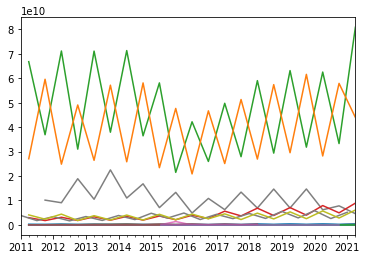

In [15]:
fig, ax = plt.subplots()

for workbook in workbooks_combined:
    if 'Operating Revenue' in workbooks_combined[workbook]['Profit Loss']:
        workbooks_combined[workbook]['Profit Loss']['Operating Revenue'].plot()


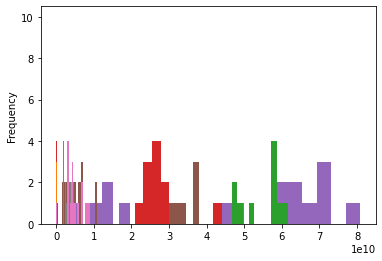

In [16]:
fig, ax = plt.subplots()

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
         if 'Operating Revenue' in workbooks_separated[workbook][period]['Profit Loss']:
                workbooks_separated[workbook][period]['Profit Loss']['Operating Revenue'].plot.hist()
   


## Ratio Analysis

## Beneish M Score Calculation and Plots

### DSRI

In [32]:
def calc_DSRI(df):
    for row in range(1, len(df)):
        t1 = df.iloc[row]
        t0 = df.iloc[row-1]
        
        if t1 != 0 and t0 != 0:
            print(t1/t0)
        else:
            print('N/A')

In [33]:
calc_DSRI(workbooks_separated['ADH']['HY']['Ratio Analysis']['Days Receivables'])

1.0491996577415115
0.966538702523148
0.06420262490417711
2.780911932045837
0.6007837939083077


In [34]:
for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
        if 'Days Receivables' in workbooks_separated[workbook][period]['Ratio Analysis']:
            print("DSRIs for", workbook, period)
            calc_DSRI(workbooks_separated[workbook][period]['Ratio Analysis']['Days Receivables'])
            print('\n')

DSRIs for ADH FY
N/A
0.9664237065360258
N/A
N/A
N/A
N/A
N/A


DSRIs for ADH HY
1.0491996577415115
0.966538702523148
0.06420262490417711
2.780911932045837
0.6007837939083077


DSRIs for BCI FY
0.35516557834336354
2.0294012216454935
0.017453341764728743
31.13014877036737
1.040871659996684
1.79713526293926
1.3797287738513384
1.8256306384608212
0.5314393981210602
1.4482725939005232


DSRIs for BCI HY
12.08788987657856
0.012255192258118454
17.288857305287095
0.7489058271486397
4.760692073123879
1.020566751210514
0.9432212476712519
0.45412902490224877
2.106028895490143


DSRIs for BFG FY
1.5741108952794
1.646240815077943
0.8990948558917797
2.2490494042652207
0.27732112080686694
1.513832722452899
1.0372552654639617
0.9930942061961933
0.7971474973564515


DSRIs for BFG HY
N/A
N/A
N/A
1.0209710012687616
0.9175129351379634
1.2095295310276277
0.9470229056286047
0.9937689489489415
0.9913030481750702
0.9795957257076765


DSRIs for BHP FY
0.7699633936959409
1.0610610905419051
0.994932452526438
0.971

<AxesSubplot:>

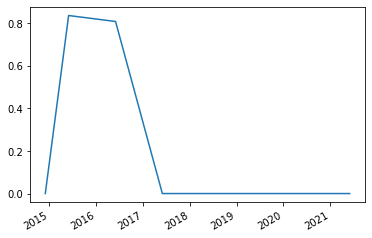

In [35]:
workbooks_separated['ADH']['FY']['Ratio Analysis']['Days Receivables'].plot()

<AxesSubplot:>

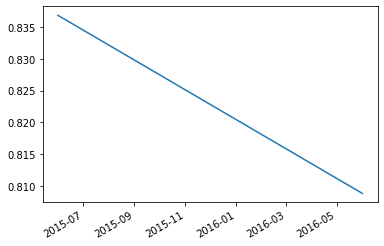

In [44]:
dffilter = workbooks_separated['ADH']['FY']['Ratio Analysis']['Days Receivables']
dffilter = dffilter[dffilter != 0]
dffilter.plot()

<AxesSubplot:>

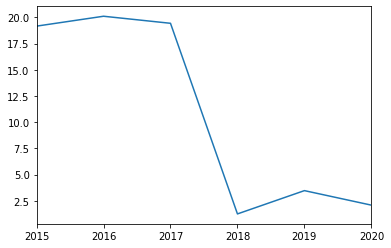

In [46]:
dffilter = workbooks_separated['ADH']['HY']['Ratio Analysis']['Days Receivables']
dffilter = dffilter[dffilter != 0]
dffilter.plot()

<AxesSubplot:>

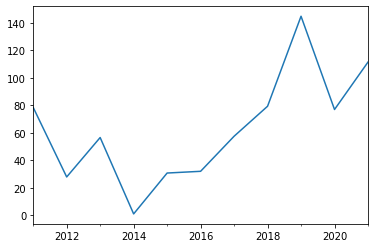

In [37]:
workbooks_separated['BCI']['FY']['Ratio Analysis']['Days Receivables'].plot()

<AxesSubplot:>

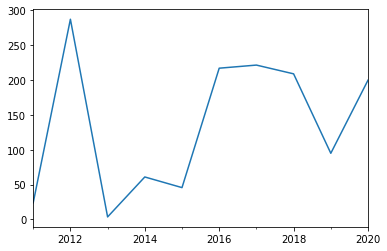

In [38]:
workbooks_separated['BCI']['HY']['Ratio Analysis']['Days Receivables'].plot()

### GMI

In [55]:
def calc_GMI(df):
    for row in range(1, len(df)):
        t1 = df.iloc[row]
        t0 = df.iloc[row-1]
        
        if t1 != 0 and t0 != 0:
            print(t1/t0)
        else:
            print('N/A')

In [56]:
calc_GMI(workbooks_separated['ADH']['FY']['Ratio Analysis']['Net Profit Margin (%)'])

N/A
7.6642857142857155
0.7390493942218079
1.2244640605296344
0.8867147270854787
1.169570267131243
1.3396226415094339


In [59]:
for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
        if 'Net Profit Margin (%)' in workbooks_separated[workbook][period]['Ratio Analysis']:
            print("GMIs for", workbook, period)
            calc_DSRI(workbooks_separated[workbook][period]['Ratio Analysis']['Net Profit Margin (%)'])
            print('\n')

GMIs for ADH FY
N/A
7.6642857142857155
0.7390493942218079
1.2244640605296344
0.8867147270854787
1.169570267131243
1.3396226415094339


GMIs for ADH HY
0.6124444444444445
1.3570391872278664
0.9828877005347594
0.794341675734494
2.6438356164383565


GMIs for BCI FY
4.792635658914729
0.8912252325111201
0.7713248638838476
-2.6788235294117646
1.1304347826086956
-0.21620046620046623
-4.608265947888589
-0.4630532267498538
0.02063157894736842
24.28571428571429


GMIs for BCI HY
2.042925278219396
1.8319066147859921
-3.115123194562447
0.8369016773489704
-0.3570148280919016
-1.6143313555454128
-2.1806615776081424
-0.1332814728380656
-0.005836575875486381


GMIs for BFG FY
-0.4411764705882352
-1.991666666666667
0.8430962343096234
2.4143920595533497
1.0010277492291881
1.1129363449691991
1.1263837638376384
1.167895167895168
1.20617110799439


GMIs for BFG HY
N/A
N/A
N/A
6.516949152542374
1.0273081924577374
0.9443037974683544
1.4718498659517427
1.3633879781420766
0.9231796927187709
1.0260492040520983


<AxesSubplot:>

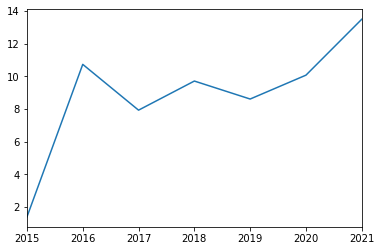

In [58]:
dffilter = workbooks_separated['ADH']['FY']['Ratio Analysis']['Net Profit Margin (%)']
dffilter = dffilter[dffilter != 0]
dffilter.plot()

### AQI

In [64]:
(workbooks_separated['ADH']['FY']['Balance Sheet']['Total Assets'] - (workbooks_separated['ADH']['FY']['Balance Sheet']['Total Current Assets']-workbooks_separated['ADH']['FY']['Balance Sheet']['NCA - PP&E']))/workbooks_separated['ADH']['FY']['Balance Sheet']['Total Assets']

2014-12-01   0.95
2015-06-01   0.83
2016-06-01   0.82
2017-06-01   0.84
2018-06-01   0.83
2019-06-01   0.77
2020-06-01   1.10
2021-06-01   1.01
dtype: float64

<AxesSubplot:>

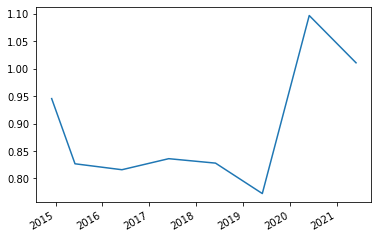

In [69]:
df =(workbooks_separated['ADH']['FY']['Balance Sheet']['Total Assets'] - (workbooks_separated['ADH']['FY']['Balance Sheet']['Total Current Assets']-workbooks_separated['ADH']['FY']['Balance Sheet']['NCA - PP&E']))/workbooks_separated['ADH']['FY']['Balance Sheet']['Total Assets']
df.plot()

In [72]:
(workbooks_separated['ADH']['HY']['Balance Sheet']['CL - Total Assets'] - (workbooks_separated['ADH']['HY']['Balance Sheet']['Total Current Assets']-workbooks_separated['ADH']['HY']['Balance Sheet']['NCA - PP&E']))/workbooks_separated['ADH']['HY']['Balance Sheet']['CL - Total Assets']

2015-12-01   0.82
2016-12-01   0.84
2017-12-01   0.83
2018-12-01   0.78
2019-12-01   1.09
2020-12-01   1.03
dtype: float64

<AxesSubplot:>

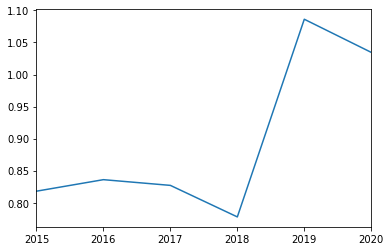

In [71]:
df =(workbooks_separated['ADH']['HY']['Balance Sheet']['CL - Total Assets'] - (workbooks_separated['ADH']['HY']['Balance Sheet']['Total Current Assets']-workbooks_separated['ADH']['HY']['Balance Sheet']['NCA - PP&E']))/workbooks_separated['ADH']['HY']['Balance Sheet']['CL - Total Assets']
df.plot()

### SGI

## Cluster Analysis

In [79]:
km = KMeans(n_clusters=2)
km


KMeans(n_clusters=2)

In [80]:
y_predicted = km.fit_predict(workbooks_separated['ADH']['FY']['Ratio Analysis'])
y_predicted

array([1, 0, 0, 1, 0, 1, 0, 0])

In [81]:
workbooks_separated['ADH']['FY']['Ratio Analysis']['Cluster Number'] = y_predicted
workbooks_separated['ADH']['FY']['Ratio Analysis'].head()


Item        Net Profit Margin (%)  EBIT Margin (%)  EBITA Margin (%)  \
2014-12-01                   0.00             0.00              0.00   
2015-06-01                   1.40             8.74              9.09   
2016-06-01                  10.73            16.09             16.34   
2017-06-01                   7.93            11.63             11.90   
2018-06-01                   9.71            14.38             14.73   

Item        EBITDA Margin (%)  ROE (%)  ROA (%)  ROIC (%)  NOPLAT Margin (%)  \
2014-12-01               0.00     0.00     0.00      0.00               0.00   
2015-06-01              10.92     7.55    16.43     50.68               6.33   
2016-06-01              18.17    28.43    16.68     44.70              11.51   
2017-06-01              13.85    20.95    11.61     39.76               8.70   
2018-06-01              16.55    26.30    16.21     55.88              10.38   

Item        Invested Capital Turnover  Inventory Turnover  ...    Net Debt  \
2014-12-01                       0.00                0.00  ... 53116000.00   
2015-06-01                       8.01               18.14  ... 32242000.00   
2016-06-01                       3.88                9.64  ... 27124000.00   
2017-06-01                       4.57                8.03  ... 27598000.00   
2018-06-01                       5.38                9.38  ... 12237000.00   

Item        Enterprise Value  EV/EBITDA  EV/EBIT  Market Cap./Rep NPAT  \
2014-12-01       53116000.00       0.00     0.00                  0.00   
2015-06-01      473469500.00      41.13    51.36               1184.50   
2016-06-01      436835250.00       9.49    10.72                 15.08   
2017-06-01      170250500.00       4.64     5.53                  6.79   
2018-06-01      382138250.00       7.34     8.44                 12.10   

Item        Market Cap./Trading Rev.  Price/Book Value  Price/Gross Cash Flow  \
2014-12-01                      0.00              0.00                   0.00   
2015-06-01                      4.18              5.66                  50.45   
2016-06-01                      1.62              4.29                  12.13   
2017-06-01                      0.54              1.42                   5.20   
2018-06-01                      1.18              3.18                   9.60   

Item          PER  Cluster Number  
2014-12-01   0.00               1  
2015-06-01 274.23               0  
2016-06-01  15.08               0  
2017-06-01   6.79               1  
2018-06-01  12.19               0  

[5 rows x 51 columns]

In [89]:
df_by_cluster = sns.lmplot(workbooks_separated['ADH']['FY']['Ratio Analysis'].index,'Days Receivables', data = workbooks_separated['ADH']['FY']['Ratio Analysis'], fit_reg=False, hue='Cluster Number')

c:\users\keert\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: Invalid comparison between dtype=datetime64[ns] and str

In [73]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [74]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [75]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()